In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import enchant
import cloudpickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
y = cloudpickle.load(open("pickles/forum_label.pkl", "rb" ) )

In [3]:
disease_db = cloudpickle.load(open("pickles/disease_db.pkl", "rb" ) )

In [4]:
tfidf = cloudpickle.load(open("pickles/forum_vecrepresent.pkl", "rb" ) )
forum_vectorizer = cloudpickle.load(open("pickles/forum_vectorizer.pkl", "rb" ) )

In [5]:
print y.shape

(13458, 72)


Just randomly assigning some pregnancies to be 0 cause they are super over represented

In [6]:
# dropi = [i for i,d in enumerate(disease_db) if d['name']=='pregnancy'][0]
# tozero = y[:,dropi]==1
# y[tozero,dropi]=1*(np.random.random((tozero.sum(),))<0.1)

In [30]:
print y[:,dropi].sum()
print tfidf.shape
print y.shape

8809
(13458, 836)
(13458, 72)


In [32]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf, y, test_size=0.25, random_state=42)

In [31]:
y.sum(axis=1)

array([1, 1, 2, ..., 2, 1, 1])

## The following is designed to evaluate whether the classifier predicts the correct labels with the highest probability

In [49]:
def top_match_score(probs,trues):
    ret = 0
    for c in range(probs.shape[0]):
        inds = np.argsort(probs[c,:])[::-1]
        sol = trues[c,:]
        spts = np.nonzero(sol)
        tret=0
        for s in spts:
            tret=tret+np.nonzero(inds==s)[0]
        div = sol.sum()
        div = div*(div+1)/2
        ret=ret+tret/div
    return ret/probs.shape[0]

In [52]:
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB().fit(tfidf_train, y_train)
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
rfscores = []
for nest in [10,20,40,100]:
    for mdep in [20,40,60,80,None]:
        print str(nest)+" "+str(mdep)
        clf = %time RandomForestClassifier(n_estimators=nest,max_depth=mdep).fit(X_train, y_train)
        with open("pickles/test_classifier.pkl", 'wb') as handle:
            cloudpickle.dump(clf, handle)
        sz = os.stat("pickles/test_classifier.pkl").st_size
        predicted = clf.predict_proba(X_test)
        prob = np.array([a[:,1] for a in predicted]).T
        auc = roc_auc_score(y_test,prob)
        ll = log_loss(y_test,prob)
        acc = accuracy_score(clf.predict(X_test), y_test)
        tms = top_match_score(prob, y_test)
        rfscores.append((sz,acc,ll,auc,tms))
        del clf


10 20
CPU times: user 8.2 s, sys: 8 ms, total: 8.2 s
Wall time: 8.21 s
10 40
CPU times: user 13.8 s, sys: 20 ms, total: 13.9 s
Wall time: 13.9 s
10 60
CPU times: user 17.7 s, sys: 28 ms, total: 17.7 s
Wall time: 17.8 s
10 80
CPU times: user 19.4 s, sys: 20 ms, total: 19.4 s
Wall time: 19.4 s
10 None
CPU times: user 23.4 s, sys: 8 ms, total: 23.4 s
Wall time: 23.4 s
20 20
CPU times: user 15.8 s, sys: 0 ns, total: 15.8 s
Wall time: 15.8 s
20 40
CPU times: user 28.2 s, sys: 36 ms, total: 28.2 s
Wall time: 28.3 s
20 60
CPU times: user 38 s, sys: 68 ms, total: 38.1 s
Wall time: 38.1 s
20 80
CPU times: user 39.1 s, sys: 40 ms, total: 39.1 s
Wall time: 39.2 s
20 None
CPU times: user 47.4 s, sys: 48 ms, total: 47.4 s
Wall time: 47.5 s
40 20
CPU times: user 32 s, sys: 4 ms, total: 32 s
Wall time: 32.1 s
40 40
CPU times: user 1min 1s, sys: 52 ms, total: 1min 1s
Wall time: 1min 1s
40 60
CPU times: user 1min 10s, sys: 204 ms, total: 1min 10s
Wall time: 1min 10s
40 80
CPU times: user 1min 19s, sys:

/home/will/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression()).fit(X_train, y_train)
with open("pickles/test_classifier.pkl", 'wb') as handle:
    cloudpickle.dump(clf, handle)
sz = sz = os.stat("pickles/test_classifier.pkl").st_size
prob = clf.predict_proba(X_test)
ll = log_loss(y_test,prob)
acc = accuracy_score(clf.predict(X_test), y_test)
tms = top_match_score(prob, y_test)
lrscore=(sz,acc,ll,auc,tms)
del clf

/home/will/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


(-1000, 1000000000.0)

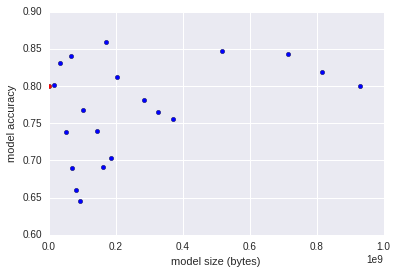

In [64]:
plt.scatter(x=[x[0] for x in rfscores],
           y=[x[3] for x in rfscores])
plt.scatter(x=sz,y=auc,c='r')
plt.xlabel('model size (bytes)')
plt.ylabel('model accuracy')
plt.xlim([-1000,1E9])

In [54]:
clf = %time RandomForestClassifier(n_estimators=40).fit(X_train, y_train)

CPU times: user 2min 11s, sys: 256 ms, total: 2min 11s
Wall time: 2min 15s


In [55]:
predicted = clf.predict_proba(X_test)
val=np.array([a[:,1] for a in predicted]).T

In [ ]:
sns.distplot(y.sum(axis=1),400)
plt.xlim(0, 50)
plt.xlabel('Flesch Kincaid Grade Level')